In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
from numpy import load

In [2]:
import seaborn as sb
import matplotlib.pyplot as plt


from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    MaxPooling2D,
    Conv2D,
    Flatten,
    BatchNormalization,
    Input,
    Average,
)

from tqdm.autonotebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import save
from numpy import load

C:\Users\gangu\AppData\Local\Temp\ipykernel_13508\2399446793.py:18: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
def load_data():
    X_test = load('Data/x_test.npy')
    data = load('Data/data.npy')
    return X_test, data

In [4]:
X_test, data = load_data()

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, stratify=data[:, -1])

In [6]:
def class_labels(y):
    c = np.unique(y)
    return c

In [7]:
def balance_classes(y_train):
    class_weights = class_weight.compute_class_weight(class_weight= 'balanced', classes = class_labels(y_train), y = y_train)
    class_weights_dict = dict(zip(class_labels(y_train), class_weights))
    return class_weights_dict

In [8]:
def normalize(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x = (x - mean)/(std + 0.01)
    return x

In [9]:
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [10]:
def reshape_input(X_train, X_val, X_test):
    
    X_train = X_train.reshape(len(X_train), 28, 56)
    X_val = X_val.reshape(len(X_val), 28, 56)
    X_test = X_test.reshape(len(X_test), 28, 56)
    
    X_train = np.expand_dims(X_train, 3)
    X_val = np.expand_dims(X_val, 3)
    X_test = np.expand_dims(X_test ,3)
    
    input_shape = X_train.shape[1:]
    model_input = Input(shape=input_shape)
    
    return X_train, X_val, X_test, input_shape, model_input

In [11]:
X_train, X_val, X_test, input_shape, model_input = reshape_input(X_train, X_val, X_test)

In [12]:
class_weights_dict = balance_classes(Y_train)

In [14]:
# define train function
def train(X, Y, model, loss, optimizer, checkpoint, metrics, batch_size, epochs):
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
    history = model.fit(
        X, 
        Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, Y_val),
        class_weight=class_weights_dict,
        callbacks=[checkpoint]
    )
    return history

In [15]:
model_Nadam = Sequential(
    [
        Conv2D(64, (3, 3), padding="same", input_shape=input_shape, activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(512, (3, 3), strides=(2,2), padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        
        Dense(19, activation="softmax"),
    ]
)

optimizer_Nadam = Nadam()

In [16]:
model_Nadam.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 56, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 28, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 28, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 14, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 14, 256)        295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 7, 256)        0

In [19]:
checkpoint_filepath_Nadam = 'model checkpoints/checkpoint_updated_final_Nadam'
model_checkpoint_callback_Nadam = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_Nadam,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [21]:
history_cnn_Nadam = train(
    X_train, Y_train, model_Nadam, "sparse_categorical_crossentropy", optimizer_Nadam, model_checkpoint_callback_Nadam, "accuracy", 1024, 200
)

Epoch 1/200
40/40 [==============================] - 10s 66ms/step - loss: 2.6201 - accuracy: 0.1057 - val_loss: 2.2962 - val_accuracy: 0.2335
Epoch 2/200
40/40 [==============================] - 2s 49ms/step - loss: 1.7489 - accuracy: 0.3006 - val_loss: 1.7646 - val_accuracy: 0.3857
Epoch 3/200
40/40 [==============================] - 2s 49ms/step - loss: 0.9959 - accuracy: 0.5957 - val_loss: 1.3615 - val_accuracy: 0.5590
Epoch 4/200
40/40 [==============================] - 2s 50ms/step - loss: 0.5039 - accuracy: 0.8148 - val_loss: 0.2657 - val_accuracy: 0.9262
Epoch 5/200
40/40 [==============================] - 2s 49ms/step - loss: 0.2123 - accuracy: 0.9250 - val_loss: 0.1922 - val_accuracy: 0.9447
Epoch 6/200
40/40 [==============================] - 2s 47ms/step - loss: 0.1431 - accuracy: 0.9507 - val_loss: 0.2192 - val_accuracy: 0.9355
Epoch 7/200
40/40 [==============================] - 2s 49ms/step - loss: 0.1011 - accuracy: 0.9636 - val_loss: 0.1821 - val_accuracy: 0.9461
Epoch

In [22]:
model_RMS = Sequential(
    [
        Conv2D(64, (3, 3), padding="same", input_shape=input_shape, activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(512, (3, 3), strides=(2,2), padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        
        Dense(19, activation="softmax"),
    ]
)

optimizer_RMS = RMSprop()

In [23]:
model_RMS.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 56, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 28, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 14, 128)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 14, 256)        295168    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 3, 7, 256)       

In [24]:
checkpoint_filepath_RMS = 'model checkpoints/checkpoint_updated_final_RMS'
model_checkpoint_callback_RMS = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_RMS,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [25]:
history_cnn_RMS = train(
    X_train, Y_train, model_RMS, "sparse_categorical_crossentropy", optimizer_RMS, model_checkpoint_callback_RMS, "accuracy", 1024, 200
)

Epoch 1/200
40/40 [==============================] - 2s 48ms/step - loss: 2.7403 - accuracy: 0.0926 - val_loss: 2.5513 - val_accuracy: 0.1439
Epoch 2/200
40/40 [==============================] - 2s 45ms/step - loss: 1.9707 - accuracy: 0.2453 - val_loss: 2.0563 - val_accuracy: 0.2989
Epoch 3/200
40/40 [==============================] - 2s 45ms/step - loss: 1.3052 - accuracy: 0.4756 - val_loss: 1.2108 - val_accuracy: 0.5963
Epoch 4/200
40/40 [==============================] - 2s 45ms/step - loss: 0.7448 - accuracy: 0.7110 - val_loss: 0.6468 - val_accuracy: 0.8075
Epoch 5/200
40/40 [==============================] - 2s 45ms/step - loss: 0.3885 - accuracy: 0.8632 - val_loss: 0.2675 - val_accuracy: 0.9272
Epoch 6/200
40/40 [==============================] - 2s 43ms/step - loss: 0.2225 - accuracy: 0.9242 - val_loss: 0.2632 - val_accuracy: 0.9233
Epoch 7/200
40/40 [==============================] - 2s 45ms/step - loss: 0.1576 - accuracy: 0.9460 - val_loss: 0.1916 - val_accuracy: 0.9452
Epoch 

In [26]:
model_SGD = Sequential(
    [
        Conv2D(64, (3, 3), padding="same", input_shape=input_shape, activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(512, (3, 3), strides=(2,2), padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        
        Dense(19, activation="softmax"),
    ]
)

optimizer_SGD = SGD()

In [27]:
model_SGD.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 56, 64)        640       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 28, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 14, 256)        295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 3, 7, 256)       

In [28]:
checkpoint_filepath_SGD = 'model checkpoints/checkpoint_updated_final_SGD'
model_checkpoint_callback_SGD = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_SGD,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [29]:
history_cnn_SGD = train(
    X_train, Y_train, model_SGD, "sparse_categorical_crossentropy", optimizer_SGD, model_checkpoint_callback_SGD, "accuracy", 1024, 200
)

Epoch 1/200
40/40 [==============================] - 2s 46ms/step - loss: 2.9487 - accuracy: 0.0582 - val_loss: 2.9405 - val_accuracy: 0.0522
Epoch 2/200
40/40 [==============================] - 2s 43ms/step - loss: 2.9407 - accuracy: 0.0609 - val_loss: 2.9387 - val_accuracy: 0.0448
Epoch 3/200
40/40 [==============================] - 2s 43ms/step - loss: 2.9363 - accuracy: 0.0576 - val_loss: 2.9366 - val_accuracy: 0.0541
Epoch 4/200
40/40 [==============================] - 2s 43ms/step - loss: 2.9306 - accuracy: 0.0629 - val_loss: 2.9346 - val_accuracy: 0.0556
Epoch 5/200
40/40 [==============================] - 2s 43ms/step - loss: 2.9243 - accuracy: 0.0622 - val_loss: 2.9298 - val_accuracy: 0.0555
Epoch 6/200
40/40 [==============================] - 2s 43ms/step - loss: 2.9163 - accuracy: 0.0652 - val_loss: 2.9250 - val_accuracy: 0.0615
Epoch 7/200
40/40 [==============================] - 2s 43ms/step - loss: 2.9071 - accuracy: 0.0687 - val_loss: 2.9196 - val_accuracy: 0.0612
Epoch 

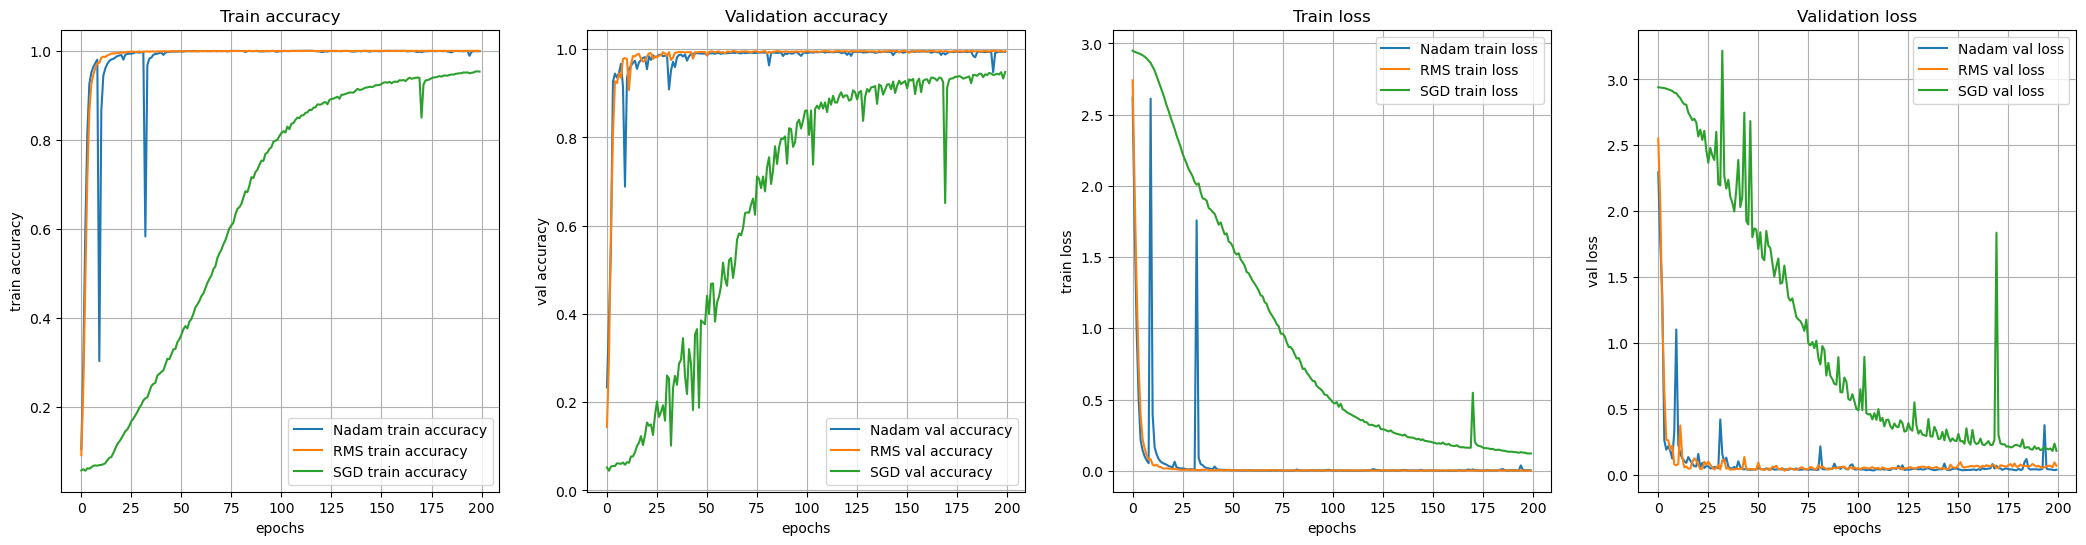

In [39]:
plt.figure(figsize=(26, 6))

plt.subplot(1, 4, 1)
plt.plot(history_cnn_Nadam.history["accuracy"])
plt.plot(history_cnn_RMS.history["accuracy"])
plt.plot(history_cnn_SGD.history["accuracy"])
plt.xlabel("epochs")
plt.ylabel("train accuracy")
plt.title("Train accuracy")
plt.legend(["Nadam train accuracy", "RMS train accuracy", "SGD train accuracy"])
plt.grid()

plt.subplot(1, 4, 2)
plt.plot(history_cnn_Nadam.history["val_accuracy"])
plt.plot(history_cnn_RMS.history["val_accuracy"])
plt.plot(history_cnn_SGD.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("val accuracy")
plt.title("Validation accuracy")
plt.legend(["Nadam val accuracy", "RMS val accuracy", "SGD val accuracy"])
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(history_cnn_Nadam.history["loss"])
plt.plot(history_cnn_RMS.history["loss"])
plt.plot(history_cnn_SGD.history["loss"])
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.title("Train loss")
plt.legend(["Nadam train loss", "RMS train loss", "SGD train loss"])
plt.grid()


plt.subplot(1, 4, 4)
plt.plot(history_cnn_Nadam.history["val_loss"])
plt.plot(history_cnn_RMS.history["val_loss"])
plt.plot(history_cnn_SGD.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("val loss")
plt.title("Validation loss")
plt.legend(["Nadam val loss", "RMS val loss", "SGD val loss"])
plt.grid()

plt.show()

Since we observe that RMS Prop not only performs the best but also is the most stable of the three optimizers we select RMSProp as our final optimizer with the default learning rate of 0.01.

### Cross validation with confusion matrix and ROC-AUC score

In [41]:
def get_predictions(x):
    model_RMS.load_weights(checkpoint_filepath_RMS)
    predictions = model_RMS.predict(x)
    Y_pred = np.argmax(predictions, axis=1)
    
    # create df and export to csv
    df_test = pd.DataFrame(Y_pred)
    df_test = df_test.rename(columns= {0: 'Class'})
    df_test = df_test.reset_index()
    df_test.to_csv('CNN_outputs/test_results_CNN_RMS.csv', index=False)
    return Y_pred, predictions

In [42]:
# generate csv
# replace with x_val to plot confusion matrix to detect potential overfitting 
Y_pred_RMS, predictions_RMS = get_predictions(X_val)

313/313 [==============================] - 1s 1ms/step


In [48]:
from sklearn.metrics import roc_auc_score

In [51]:
roc_auc_score(Y_val, predictions_RMS, multi_class='ovr')

0.9998652714185425

In [43]:
def plot_cf(Y_true, Y_pred):
    cf = confusion_matrix(Y_val, Y_pred)
    plt.figure(figsize=(20, 20))
    sb.heatmap(cf, annot=True)
    return None

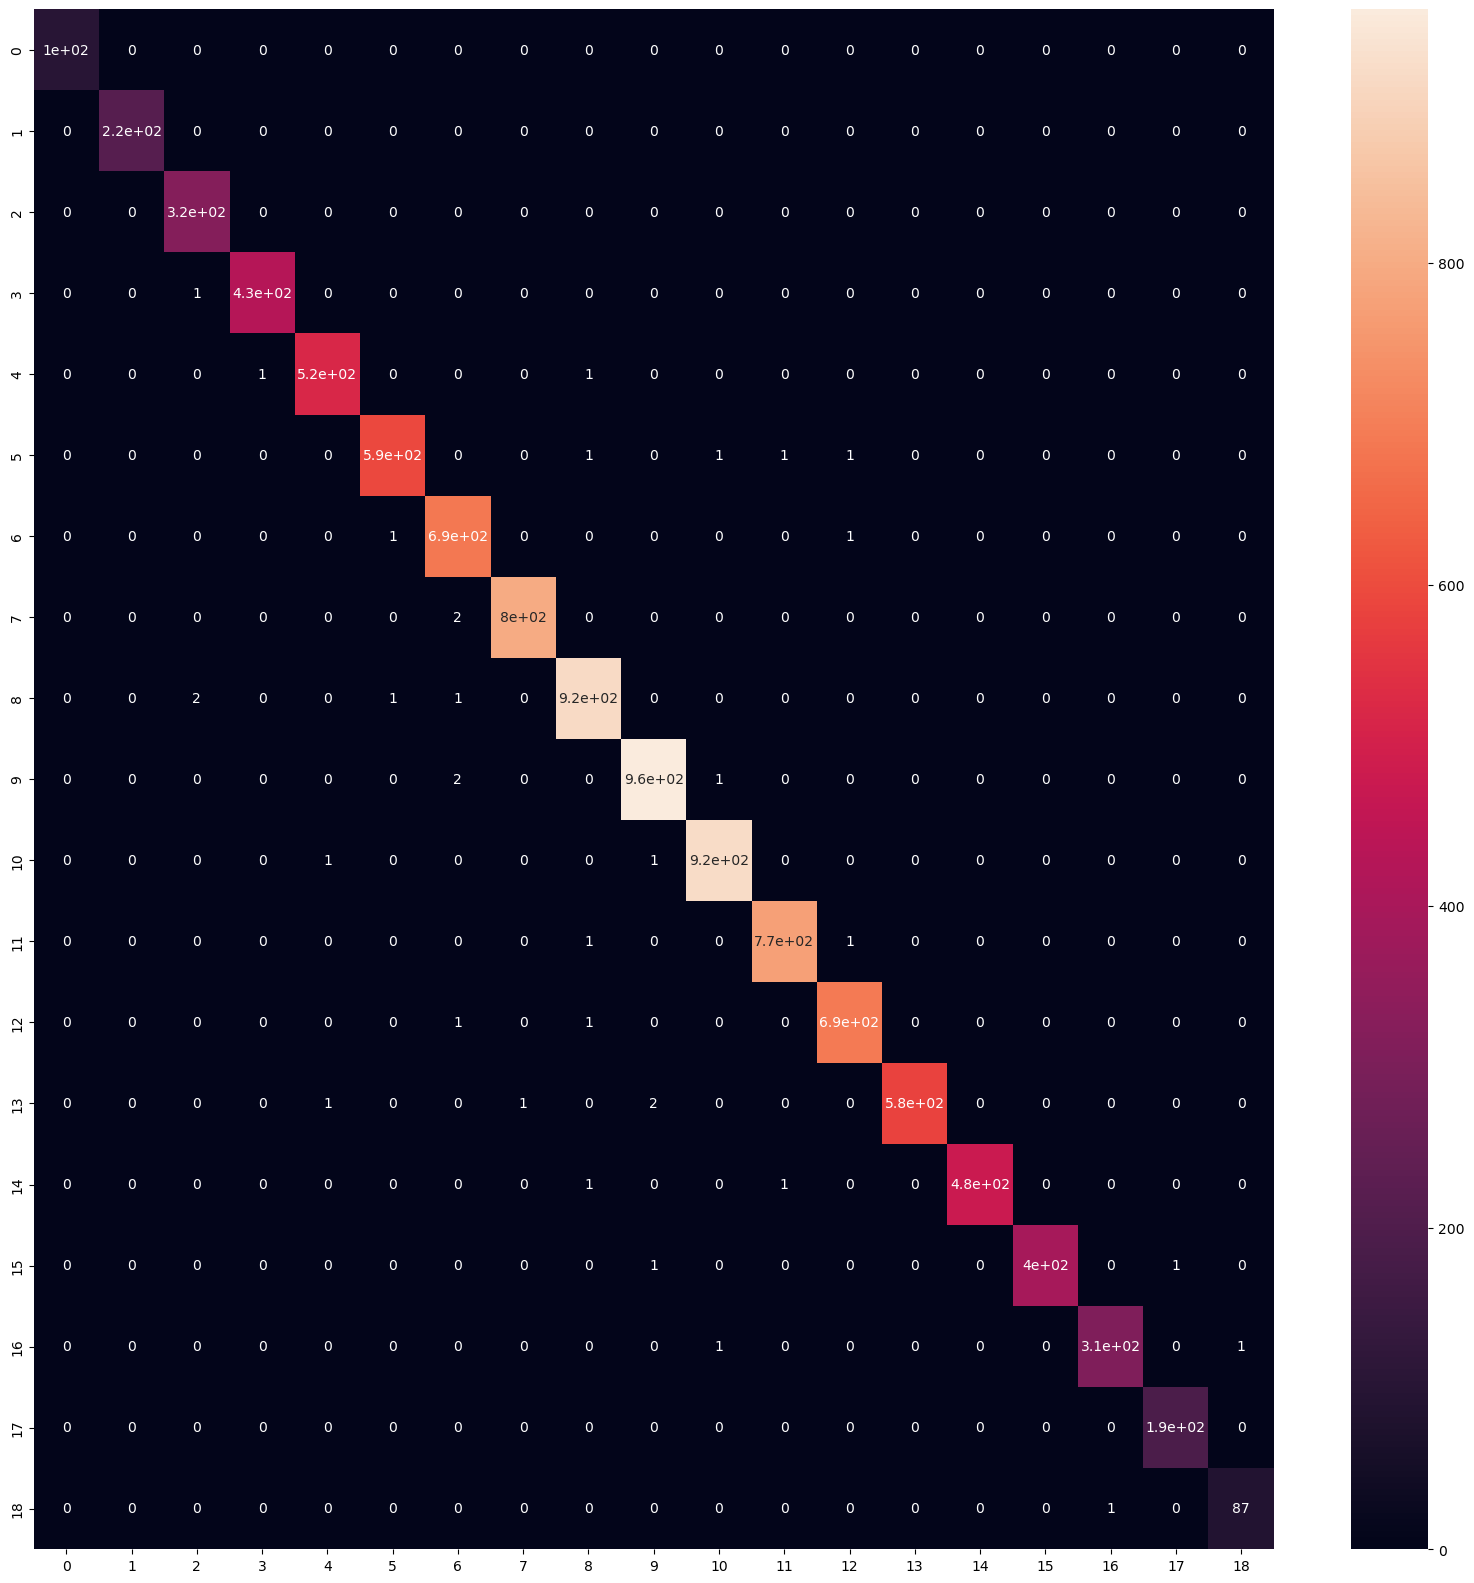

In [44]:
plot_cf(Y_val, Y_pred_RMS)

In [52]:
Y_pred_RMS_test, predictions_RMS_test = get_predictions(X_test)

313/313 [==============================] - 1s 2ms/step


# Training with full data using tuned hyper-parameters

In [53]:
X = data[:,:-1]
Y = data[:,-1].astype(int)

In [54]:
X = normalize(X)

In [55]:
X = X.reshape(len(X), 28, 56)
X = np.expand_dims(X ,3)

In [56]:
class_weights_dict = balance_classes(Y)

In [57]:
history_cnn_final_RMS = train(
    X, Y, model_RMS, "sparse_categorical_crossentropy", optimizer_RMS, model_checkpoint_callback_RMS, "accuracy", 1024, 200
)

Epoch 1/200
49/49 [==============================] - 4s 70ms/step - loss: 0.0184 - accuracy: 0.9983 - val_loss: 0.0073 - val_accuracy: 0.9985
Epoch 2/200
49/49 [==============================] - 2s 44ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0040 - val_accuracy: 0.9991
Epoch 3/200
49/49 [==============================] - 2s 44ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0034 - val_accuracy: 0.9996
Epoch 4/200
49/49 [==============================] - 2s 44ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0033 - val_accuracy: 0.9990
Epoch 5/200
49/49 [==============================] - 2s 45ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0017 - val_accuracy: 0.9998
Epoch 6/200
49/49 [==============================] - 2s 45ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 0.9997
Epoch 7/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 2.1386e-04 - val_accuracy: 0.9999
Ep

In [58]:
model_RMS.save('model checkpoints/saved_model_final')

INFO:tensorflow:Assets written to: model checkpoints/saved_model_final\assets


INFO:tensorflow:Assets written to: model checkpoints/saved_model_final\assets


In [59]:
def get_predictions_final(x):
    predictions = model_RMS.predict(x)
    Y_pred = np.argmax(predictions, axis=1)
    
    # create df and export to csv
    df_test = pd.DataFrame(Y_pred)
    df_test = df_test.rename(columns= {0: 'Class'})
    df_test = df_test.reset_index()
    df_test.to_csv('CNN_outputs/test_results_CNN_RMS_final.csv', index=False)
    return Y_pred, predictions

In [60]:
Y_pred_final, predictions_RMS_final = get_predictions_final(X_test)

313/313 [==============================] - 1s 2ms/step
